# NMR Signal Analysis Walkthrough

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import optimize

## Standard Proton Example
- Import raw phase signal and baseline

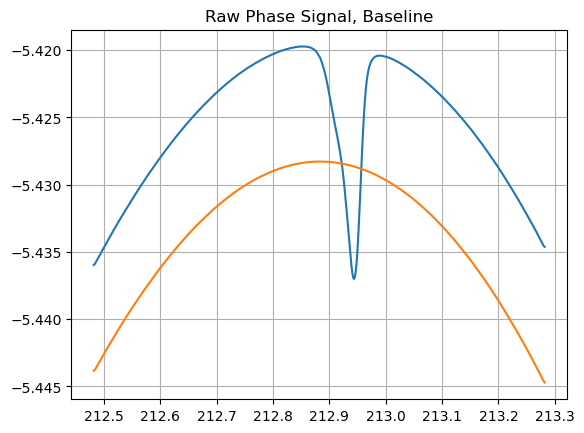

In [3]:
phase = []
baseline = []
freq_list = []

with open("10_9_22_proton.json","r") as event:
    for line in event:
        json_dict = json.loads(line.rstrip('\n|\r'))
        phase = np.array(json_dict['phase'])
        baseline = np.array(json_dict['basesweep'])
        freq_list = np.array(json_dict['freq_list'])

plt.plot(freq_list, phase)
plt.plot(freq_list, baseline)
plt.grid()
plt.title('Raw Phase Signal, Baseline')
plt.show()


- Subtact baseline from signal

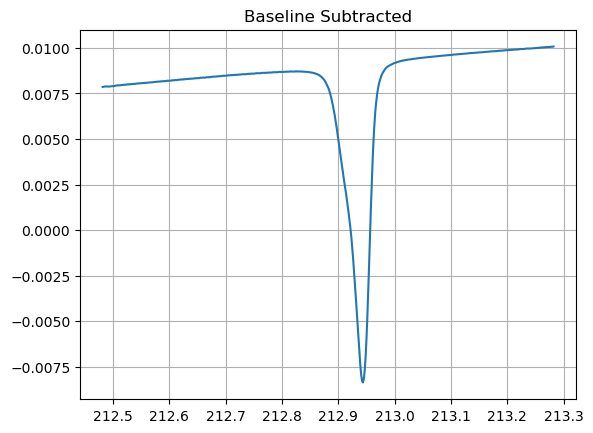

In [4]:
basesub = phase - baseline

plt.plot(freq_list, basesub)
plt.grid()
plt.title('Baseline Subtracted')
plt.show()


- Determine portion to fit using "wings" as bounds

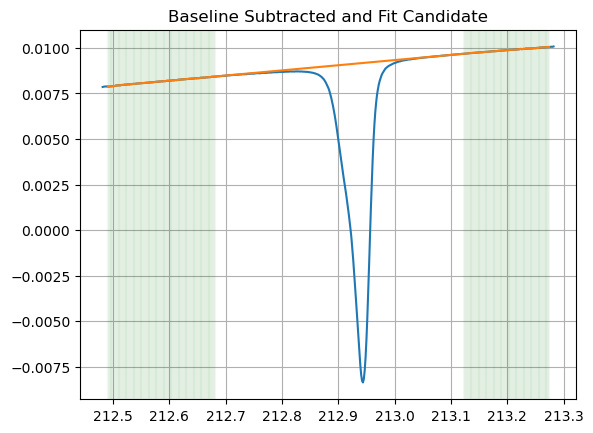

In [8]:
wings = [0.01, .25, .8, .99]  
bounds = [x * len(basesub) for x in wings]
data = [z for x, z in enumerate(zip(freq_list, basesub)) if (bounds[0] < x < bounds[1] or bounds[2] < x < bounds[3])]
# There's surely a better way to do this with NumPy, but I was initially working with Python lists

X = np.array([x for x, y in data])   
Y = np.array([y for x, y in data])

plt.plot(freq_list, basesub)
for x in X:
    plt.axvline(x, color='green', alpha=0.05,)
plt.plot(X, Y)
plt.title('Baseline Subtracted and Fit Candidate')
plt.grid()
plt.show()

- Perform polynomial fit and subtract

/scratch/slurm/48199522/.cache/tmp/ipykernel_394121/1623514278.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  pf, pcov = optimize.curve_fit(poly3, X, Y, p0=pi)


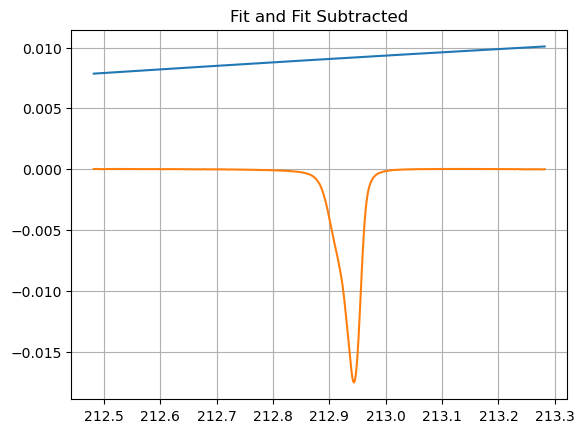

In [9]:
def poly3(x, *p):  # default poly is 3rd order
    return p[0] + p[1] * x + p[2] * np.power(x, 2) + p[3] * np.power(x, 3)

pi = [0.01, 0.8, 0.01, 0.001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001]
pf, pcov = optimize.curve_fit(poly3, X, Y, p0=pi)
pstd = np.sqrt(np.diag(pcov))

fit = poly3(freq_list, *pf)
sub = basesub - fit

plt.plot(freq_list, fit)
plt.plot(freq_list, sub)
plt.title('Fit and Fit Subtracted')
plt.grid()
plt.show()


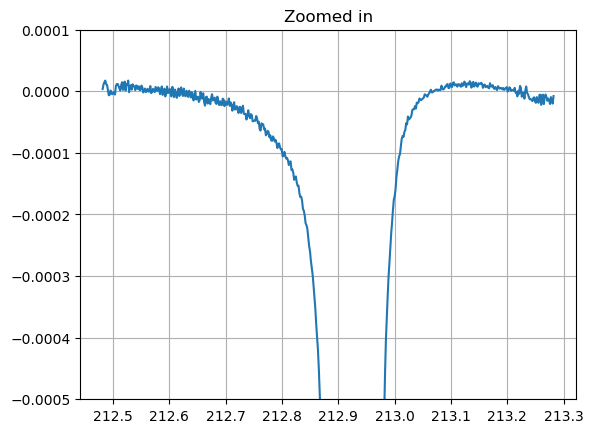

In [54]:

plt.plot(freq_list, sub)
plt.ylim(-0.0005,0.0001)
plt.title('Zoomed in')
plt.grid()
plt.show()

- Sometimes it doesn't do the best job! Small effect, but clearly there is room for improvement.
- Final area result is just the summed signal, which we multiply by the calibration constant to get the polarization. For this signal, the online CC was -1.59.

In [59]:
area = sub.sum()
pol = area * -1.594777
print("Summed final signal:",area)
print("Polarization:", pol)

Summed final signal: -0.496980497481311
Polarization: 0.7925730668317527
